In [ ]:
#!pip install -e ../../


In [29]:
# Copyright (c) 2020 Akihiro Nitta
# All rights reserved.

from __future__ import print_function, division
import os
from torchvision.datasets.vision import VisionDataset
from PIL import Image
from collections import defaultdict
import logging
import json
import collections
import torch
import math


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

LABEL_TO_STRING = {
    11: "Fixed-wing Aircraft",
    12: "Small Aircraft",
    13: "Passenger/Cargo Plane",
    15: "Helicopter",
    17: "Passenger Vehicle",
    18: "Small Car",
    19: "Bus",
    20: "Pickup Truck",
    21: "Utility Truck",
    23: "Truck",
    24: "Cargo Truck",
    25: "Truck Tractor w/ Box Trailer",
    26: "Truck Tractor",
    27: "Trailer",
    28: "Truck Tractor w/ Flatbed Trailer",
    29: "Truck Tractor w/ Liquid Tank",
    32: "Crane Truck",
    33: "Railway Vehicle",
    34: "Passenger Car",
    35: "Cargo/Container Car",
    36: "Flat Car",
    37: "Tank car",
    38: "Locomotive",
    40: "Maritime Vessel",
    41: "Motorboat",
    42: "Sailboat",
    44: "Tugboat",
    45: "Barge",
    47: "Fishing Vessel",
    49: "Ferry",
    50: "Yacht",
    51: "Container Ship",
    52: "Oil Tanker",
    53: "Engineering Vehicle",
    54: "Tower crane",
    55: "Container Crane",
    56: "Reach Stacker",
    57: "Straddle Carrier",
    59: "Mobile Crane",
    60: "Dump Truck",
    61: "Haul Truck",
    62: "Scraper/Tractor",
    63: "Front loader/Bulldozer",
    64: "Excavator",
    65: "Cement Mixer",
    66: "Ground Grader",
    71: "Hut/Tent",
    72: "Shed",
    73: "Building",
    74: "Aircraft Hangar",
    76: "Damaged Building",
    77: "Facility",
    79: "Construction Site",
    83: "Vehicle Lot",
    84: "Helipad",
    86: "Storage Tank",
    89: "Shipping container lot",
    91: "Shipping Container",
    93: "Pylon",
    94: "Tower",
}

class XviewDataset(VisionDataset):
    """xView object detection dataset.
    
    Args:
        root_dir (string): Directory with all the images.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """
    
    def __init__(self, root, annFile, transform=None):
        import os, json, collections

        self.root = root
        self.annFile = annFile
        self.transform = transform

        # Load annotations
        with open(self.annFile) as f:
            anns = json.load(f)

        self.objects = {}  # object_id -> object
        self.ids = set()

        for idx, feat in enumerate(anns['features']):
            obj_id = idx
            image_id = feat['properties']['image_id']

            base, ext = os.path.splitext(image_id)
            img_path = os.path.join(self.root, f"{base}_1_1{ext}") # check if name_1_1.tif is there, therefore we assume name.tif was 
            # present in the original dataset and also name_6_6.tif should be there
            if not os.path.exists(img_path):
                logging.info(f'{img_path} skipped because it was not found')
                continue

            self.ids.add(image_id)
            self.objects[obj_id] = {
                "image_id": image_id,
                "bbox": feat['properties']['bounds_imcoords'],
                "type_id": feat['properties']['type_id']
            }

        # Create mapping from image_id to all object_ids
        self.image_id_to_object_ids = collections.defaultdict(list)
        for obj_id, obj in self.objects.items():
            self.image_id_to_object_ids[obj["image_id"]].append(obj_id)

        # Keep ids only for images that still exist
        self.ids = list(self.ids)


    def filter_invalid_boxes(self, target):
        boxes = target["boxes"]
        # keep only boxes with strictly positive width & height
        keep = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        target["boxes"] = boxes[keep]
        if "labels" in target:
            target["labels"] = target["labels"][keep]
        return target

    def adjust_boxes_for_tile(self, target, grid_coordinates, tile_size=512):
        """
        Adjust bounding boxes to a tile's local coordinate system.

        Args:
            target (dict): Must contain 'boxes' (list of [x_min, y_min, x_max, y_max]) and 'labels'.
            grid_coordinates (tuple): (row, col) 0-based or 1-based (assume 1-based here).
            tile_size (int): Size of each tile in pixels.

        Returns:
            dict: target with boxes adjusted to tile-local coordinates.
        """
        if not isinstance(target, dict) or "boxes" not in target:
            raise RuntimeError("Target must contain 'boxes'.")

        row, col = grid_coordinates
        x_offset = (col - 1) * tile_size
        y_offset = (row - 1) * tile_size

        new_boxes = []
        new_labels = []

        for box, label in zip(target["boxes"], target["labels"]):
            x_min, y_min, x_max, y_max = box

            # Shift box to tile-local coordinates
            x_min_tile = x_min - x_offset
            y_min_tile = y_min - y_offset
            x_max_tile = x_max - x_offset
            y_max_tile = y_max - y_offset

            # Clip box to tile boundaries
            x_min_tile = max(0, x_min_tile)
            y_min_tile = max(0, y_min_tile)
            x_max_tile = min(tile_size, x_max_tile)
            y_max_tile = min(tile_size, y_max_tile)

            def ensure_tensor(x, dtype=torch.float32):
                if not isinstance(x, torch.Tensor):
                    return torch.tensor(x, dtype=dtype)
                return x

            x_min_tile = ensure_tensor(x_min_tile)
            y_min_tile = ensure_tensor(y_min_tile)
            x_max_tile = ensure_tensor(x_max_tile)
            y_max_tile = ensure_tensor(y_max_tile)

            # Only keep boxes that are at least partially inside the tile
            if x_max_tile > x_min_tile and y_max_tile > y_min_tile:
                new_box = torch.stack([x_min_tile, y_min_tile, x_max_tile, y_max_tile])
                if not isinstance(new_box, torch.Tensor):
                    raise RuntimeError()
                new_boxes.append(new_box)
                new_labels.append(torch.Tensor(label))

        if len(new_boxes) > 0:
            target["boxes"] = torch.stack(new_boxes).float()
        else:
            target["boxes"] = torch.empty((0, 4), dtype=torch.float32)

        if len(new_labels) > 0:
            target["labels"] = torch.stack(new_labels).to(torch.int64)
        else:
            target["labels"] = torch.empty((0,), dtype=torch.int64)


        labels = target.get("labels")
        if isinstance(labels, list):
            if len(labels) == 1 and torch.is_tensor(labels[0]):
                target["labels"] = labels[0]
            else:
                raise TypeError(
                    f"Expected target['labels'] to be a list with exactly one Tensor element, "
                    f"but got list of length {len(labels)} with element types {[type(l) for l in labels]} "
                    f"and values {labels}"
                )
        elif not torch.is_tensor(labels):
            raise TypeError(
                f"Expected target['labels'] to be either a list with one Tensor or a Tensor, "
                f"but got type {type(labels)} with value {labels}"
            )

        return target


    def target_list_to_dict(self, target_list):
        if len(target_list) == 0:
            return {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64)
            }
        boxes = torch.tensor([list(map(float, t['bbox'].split(','))) for t in target_list], dtype=torch.float32)
        labels = torch.tensor([t['type_id'] for t in target_list], dtype=torch.int64)
        return {"boxes": boxes, "labels": labels}


    def get_grid_coordinates(self, index, grid_size=6):
        """
        Maps a sequential index to (row, col) coordinates for a square grid.
        
        Args:
            index (int): The sequential index (0 to 35).
            grid_size (int): The size of the grid (e.g., 6 for 6x6).
            
        Returns:
            tuple: A tuple (row_id, col_id) where IDs are 1-based.
        """
        if not 0 <= index < grid_size * grid_size:
            raise ValueError(f"Index must be between 0 and {grid_size*grid_size - 1}.")
        
        row_id = index // grid_size + 1
        col_id = index % grid_size + 1
        
        return row_id, col_id

    def generate_cropped_filename(self, original_img_id, grid_coords):
        """
        Generates a new filename for a cropped tile based on the original image ID
        and the grid coordinates.

        Args:
            original_img_id (str): The original image filename (e.g., 'xyz.tif').
            grid_coords (tuple): A tuple (row_id, col_id) where IDs are 1-based.

        Returns:
            str: The new filename (e.g., 'xyz_1_1.tif').
        """
        # Split the filename into the base name and extension
        base_name, ext = os.path.splitext(original_img_id)

        # Unpack the row and column IDs from the tuple
        row_id, col_id = grid_coords

        # Create the new filename with the specified pattern
        new_filename = f"{base_name}_{row_id}_{col_id}{ext}"

        return new_filename

    def __getitem__(self, index):
        img_id = self.ids[math.floor(index/36)]
        ann_ids = self.image_id_to_object_ids[img_id]
        target = [self.objects[ann_id] for ann_id in ann_ids]

        grid_coordinates = self.get_grid_coordinates(index%36)

        target = self.target_list_to_dict(target)
        target = self.filter_invalid_boxes(target)
        target = self.adjust_boxes_for_tile(target, grid_coordinates)

        img_id = self.generate_cropped_filename(img_id, grid_coordinates)
        fname = os.path.join(self.root, img_id)  # don't append .tif if it's already in img_id


        img = Image.open(fname).convert("RGB")


        if self.transform is not None :
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.ids) * 36 # (because we have 6x6 tiles per image)



In [31]:
ds = XviewDataset(data_dir = '/dccstor/terratorch/users/rkie/data/xview/train_images_cropped', ann_file = '/dccstor/terratorch/users/rkie/data/xview/xView_train.geojson')

TypeError: XviewDataset.__init__() got an unexpected keyword argument 'data_dir'

In [ ]:
import os
import logging
from torch.utils.data import DataLoader
from lightning.pytorch import LightningDataModule
from torchvision import transforms
import torch
import torch.nn.functional as F
from torchvision.models.detection.transform import GeneralizedRCNNTransform




class XviewDataModule(LightningDataModule):

    def __init__(self, data_dir, ann_file, batch_size=8, num_workers=4, img_transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.ann_file = ann_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_transform = img_transform or transforms.ToTensor()

    def setup(self, stage=None):
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(f"Data directory not found: {self.data_dir}")
        if not os.path.isfile(self.ann_file):
            raise FileNotFoundError(f"Annotation file not found: {self.ann_file}")

        self.xv_dataset = XviewDataset(
            root=self.data_dir,
            annFile=self.ann_file,
            transform=self.img_transform
        )
  
    def detection_collate(self, batch):
        """
        Collate function for TorchVision object detection datasets.
        Returns:
            images: Tensor [B,C,Hmax,Wmax]
            targets: List[dict], each dict has 'boxes' [N,4] and 'labels' [N]
        """
        images = [item[0] for item in batch]
        annots_batch = [item[1] for item in batch]

        """         # pad images to max H,W
        max_h = max(img.shape[1] for img in images)
        max_w = max(img.shape[2] for img in images)
        padded_images = []
        for img in images:
            c, h, w = img.shape
            pad = (0, max_w - w, 0, max_h - h)  # left, right, top, bottom
            padded_images.append(F.pad(img, pad, value=0.0))
        images_tensor = torch.stack(padded_images, dim=0)  # [B,C,Hmax,Wmax] """

        images_tensor = torch.stack(images, dim=0)

        # prepare targets
        targets = []
        #for annots in annots_batch:
        #    boxes = torch.tensor([
        #        list(map(float, obj['bbox'].split(','))) for obj in annots
        #    ], dtype=torch.float32) if annots else torch.zeros((0, 4), dtype=torch.float32)
#
 #           labels = torch.tensor([
  #              int(obj['type_id']) for obj in annots
   #         ], dtype=torch.int64) if annots else torch.zeros((0,), dtype=torch.int64)
#
 #           targets.append({
  #              'boxes': boxes,
   #             'labels': labels
    #        })


        return { 'image': images_tensor, 'boxes': [d["boxes"] for d in annots_batch], 'labels': [d["labels"] for d in annots_batch] }



    def train_dataloader(self):
        return DataLoader(
            self.xv_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.detection_collate,
        )

    def val_dataloader(self):
        return DataLoader(
            self.xv_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.detection_collate,
        )

    def test_dataloader(self):
        return DataLoader(
            self.xv_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.detection_collate,
        )


In [1]:
import time

start_total = time.time()

t0 = time.time()
import logging
print("logging import:", time.time() - t0, "seconds")

t0 = time.time()
from terratorch.tasks import ObjectDetectionTask
print("ObjectDetectionTask import:", time.time() - t0, "seconds")

t0 = time.time()
#from terratorch.datamodules.xview import XviewDataModule
print("XviewDataModule import:", time.time() - t0, "seconds")

t0 = time.time()
from lightning.pytorch import Trainer
print("Trainer import:", time.time() - t0, "seconds")

t0 = time.time()
from torchvision import transforms
print("torchvision.transforms import:", time.time() - t0, "seconds")

print("Total import time:", time.time() - start_total, "seconds")

import torch

logging import: 3.6716461181640625e-05 seconds


/dccstor/terratorch/users/rkie/gitco/terratorch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ObjectDetectionTask import: 152.93634247779846 seconds
XviewDataModule import: 2.574920654296875e-05 seconds
Trainer import: 5.316734313964844e-05 seconds
torchvision.transforms import: 3.719329833984375e-05 seconds
Total import time: 152.93691277503967 seconds


In [ ]:
#!wget https://raw.githubusercontent.com/akihironitta/xView-PyTorch/refs/heads/master/datasets.py
#!mv datasets.py ../../terratorch/datasets/xview.py


In [ ]:
img_transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor()
])

dm = XviewDataModule(data_dir = '/dccstor/terratorch/users/rkie/data/xview/train_images_cropped', ann_file = '/dccstor/terratorch/users/rkie/data/xview/xView_train.geojson', img_transform = img_transform)

import json
with open('/dccstor/terratorch/users/rkie/data/xview/xView_train.geojson') as f:
    anns = json.load(f)

s = set()
for i, f in enumerate(anns['features']):
    s.add(f['properties']['image_id'])

for setitem in s:
    print(setitem)

In [ ]:
#dm.setup()

#dl = dm.train_dataloader()


In [ ]:
#item = next(iter(dl))

In [ ]:
#item

In [ ]:
#item['boxes_labels']

In [ ]:
#type(images)


In [ ]:
import os
os.environ["HF_TOKEN"] = ""


In [ ]:
model_args = {
    "framework": "faster-rcnn",
    "backbone": "terramind_v1_tiny",
    "backbone_pretrained": True,
    "num_classes": 100,
    "framework_min_size": 512,
    "framework_max_size": 512,
    "backbone_modalities": ["RGB"],
    "in_channels": 3,
    "necks": [
        {
            "name": "SelectIndices",
            "indices": [2, 5, 8, 11]
        },
        {
            "name": "ReshapeTokensToImage",
            "remove_cls_token": False
        },
        {
            "name": "LearnedInterpolateToPyramidal"
        },
        {
            "name": "FeaturePyramidNetworkNeck"
        }
    ]
}
task = ObjectDetectionTask(model_factory='ObjectDetectionModelFactory', model_args=model_args, freeze_backbone=True,
    lr=1e-7,
)

In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
import torch

checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints",
    filename="odet-{epoch:02d}-{val_loss:.2f}",
    save_last=True,
)

In [ ]:
#task = ObjectDetectionTask.load_from_checkpoint("./checkpoints/last-v9.ckpt")

In [ ]:
"""
from terratorch.tasks import ObjectDetectionTask
from peft import get_peft_model, LoraConfig, TaskType

# Grab the underlying model
model = task.model

# Configure LoRA (target the Linear layers inside the detection head)
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,   # PEFT has no DETECTION type, treat head like classification
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["cls_score", "bbox_pred"]  # detection head layers
)

# Wrap model with PEFT
peft_model = get_peft_model(model, peft_config)

# Plug back into the task
task.model = peft_model
"""


In [ ]:
trainer = Trainer(
    devices=1,
    accelerator="gpu",
    max_epochs=100,
    default_root_dir='output',
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    callbacks=[checkpoint_cb],
    logger=True,
    limit_train_batches=0.05,
    limit_val_batches=0.05,    
    limit_test_batches=0.05,
)

In [ ]:
trainer.fit(model=task, datamodule=dm)  

In [2]:
model = ObjectDetectionTask.load_from_checkpoint("./checkpoints/last-v14.ckpt")

/dccstor/terratorch/users/rkie/gitco/terratorch/.venv/lib/python3.12/site-packages/terratorch/tasks/object_detection_task.py:86: UserWarning: The Object Detection Task has to be considered experimental. This is less mature than the other tasks and being further improved.
  warnings.warn("The Object Detection Task has to be considered experimental. This is less mature than the other tasks and being further improved.")


In [ ]:
!wget https://challenge.xviewdataset.org/static/example_unlabeled.jpg

In [ ]:
files = os.listdir('../../../../data/xview/train_images/')

In [ ]:
import torch
from torchvision.transforms import functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from terratorch.models.object_detection_model_factory import ModelOutputObjectDetection
import math

def run_tiled_inference(model, img, tile_size=504, pad=21, score_thresh=0.5, device="cpu", align_to_multiple=21):
    """Run inference on large images using tiling approach with proper alignment"""
    model.eval()
    
    img_tensor = F.to_tensor(img).to(device)
    _, H_padded, W_padded = img_tensor.shape

    all_boxes, all_scores, all_labels = [], [], []

    # Calculate steps ensuring tiles overlap properly with padding
    y_steps = list(range(0, 3072, 512))
    x_steps = list(range(0, 3072, 512))

    for y in y_steps:
        for x in x_steps:
           
            # Extract tile
            tile_tensor = img_tensor[:, y:y+512, x:x+512].unsqueeze(0)

            with torch.no_grad():
                output: ModelOutputObjectDetection = model(tile_tensor)

            out_dict = output.output[0] if isinstance(output.output, list) else output.output
            boxes = out_dict.get("boxes", torch.empty(0, 4, device=device))
            scores = out_dict.get("scores", torch.empty(0, device=device))
            labels = out_dict.get("labels", torch.empty(0, dtype=torch.long, device=device))

            if boxes.numel() > 0:
                # Adjust box coordinates back to the original image space
                boxes[:, [0, 2]] += x1
                boxes[:, [1, 3]] += y1

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)

    if all_boxes:
        all_boxes = torch.cat(all_boxes)
        all_scores = torch.cat(all_scores)
        all_labels = torch.cat(all_labels)
    else:
        all_boxes = torch.empty(0, 4)
        all_scores = torch.empty(0)
        all_labels = torch.empty(0, dtype=torch.long)

    keep = all_scores >= score_thresh
    filtered_boxes = all_boxes[keep]
    filtered_scores = all_scores[keep]
    filtered_labels = all_labels[keep]
    
    return filtered_boxes, filtered_scores, filtered_labels

# Load and process image
image_name = files.pop()
img_path = f"../../../../data/xview/train_images/{image_name}"
img = Image.open(img_path).convert("RGB")
img = img.crop((0, 0, 3072, 3072))

# Run inference
boxes, scores, labels = run_tiled_inference(
    model, 
    img, 
    tile_size=512,
    pad=6,
    device="cpu"
)

# Print detected boxes
print("\nDetected Objects:")
print("----------------")
for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
    x1, y1, x2, y2 = box.tolist()
    print(f"Object {i+1}:")
    print(f"  Label: {label.item()}")
    print(f"  Confidence: {score.item():.4f}")
    print(f"  Bounding Box: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")
    print(f"  Width: {x2-x1:.1f}px, Height: {y2-y1:.1f}px")
    print("----------------")

# Visualization
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(img)
for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box.tolist()
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-5, f"{label.item()}:{score:.2f}", color='yellow', fontsize=12)
plt.title(f"Detected Objects: {len(boxes)}", fontsize=14)
plt.show()

In [ ]:
img_path = "../../../../data/xview/train_images/10.tif"
img = Image.open(img_path).convert("RGB")

In [ ]:
cropped_img = img.crop((0, 0, 3072, 3072))

In [ ]:
cropped_img.size

In [3]:
from terratorch.models.object_detection_model_factory import ModelOutputObjectDetection
import torch
from torch import Tensor

class ONNXWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        out = self.model(*args, **kwargs)

        # --- Handle ModelOutputObjectDetection ---
        if isinstance(out, ModelOutputObjectDetection):
            if isinstance(out.output, dict):
                # Single image
                boxes = out.output.get("boxes", torch.empty(0, 4))
                scores = out.output.get("scores", torch.empty(0))
                labels = out.output.get("labels", torch.empty(0, dtype=torch.long))
                return boxes, scores, labels

            elif isinstance(out.output, list):
                # Batch: flatten all boxes/scores/labels into single tensors
                all_boxes, all_scores, all_labels = [], [], []
                for item in out.output:
                    all_boxes.append(item.get("boxes", torch.empty(0, 4)))
                    all_scores.append(item.get("scores", torch.empty(0)))
                    all_labels.append(item.get("labels", torch.empty(0, dtype=torch.long)))

                boxes = torch.cat(all_boxes, dim=0) if all_boxes else torch.empty(0, 4)
                scores = torch.cat(all_scores, dim=0) if all_scores else torch.empty(0)
                labels = torch.cat(all_labels, dim=0) if all_labels else torch.empty(0, dtype=torch.long)
                return boxes, scores, labels

        # --- If it's already a tensor ---
        if isinstance(out, Tensor):
            return out

        # --- Fallback ---
        raise TypeError(f"Unsupported model output type: {type(out)}")



In [4]:
onnx_model = ONNXWrapper(model)

In [5]:
onnx_model.eval()


ONNXWrapper(
  (model): ObjectDetectionTask(
    (model): ObjectDetectionModel(
      (torchvision_model): FasterRCNN(
        (transform): GeneralizedRCNNTransform(
            Normalize(mean=[0 0 0], std=[1 1 1])
            Resize(min_size=(512,), max_size=512, mode='bilinear')
        )
        (backbone): BackboneWrapper(
          (backbone): TerraMindViT(
            (encoder_embeddings): ModuleDict(
              (untok_sen2rgb@224): ImageEncoderEmbedding(
                (proj): Linear(in_features=768, out_features=192, bias=False)
              )
            )
            (encoder): ModuleList(
              (0-11): 12 x Block(
                (norm1): LayerNorm()
                (attn): Attention(
                  (qkv): Linear(in_features=192, out_features=576, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=192, out_features=192, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=False)
   

In [12]:

dummy_input = torch.randn(1, 3, 512,512)  # batch size 1, 10 features


tensor([18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 73, 18, 18, 73, 73, 18, 18, 18, 18,
        73, 73, 18, 18, 18, 18, 18, 73, 18, 18, 18, 73, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 73, 18, 18, 18])

In [18]:
!ls ../../../../data/xview/train_images_cropped_1346/1346_5_6.tif

../../../../data/xview/train_images_cropped_1346/1346_5_6.tif


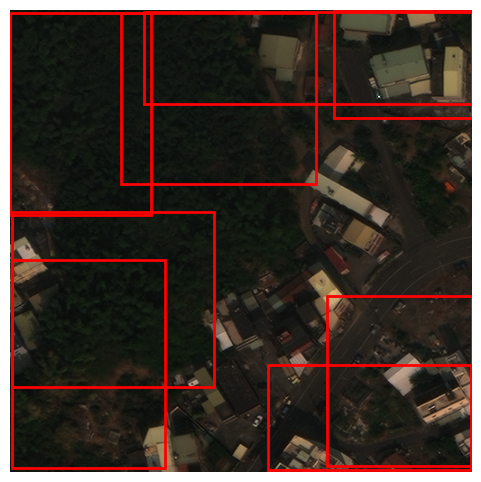

In [28]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- Load tif image ---
img_path = "../../../../data/xview/train_images_cropped_1346/1346_5_6.tif"  # replace with your tif file
img = Image.open(img_path).convert("RGB")  # ensure 3 channels


# --- Plot ---
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img)
boxes = onnx_model(dummy_input)[0]
scores = onnx_model(dummy_input)[1]
labels = onnx_model(dummy_input)[2]
# --- Example scores ---

# --- Filter boxes by threshold ---
mask = (labels == 73)
#threshold = 0.4
#mask = scores > threshold
boxes = boxes[mask]
scores = scores[mask]

# Draw each box
for box in boxes:
    xmin, ymin, xmax, ymax = box.tolist()
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle(
        (xmin, ymin), width, height,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

plt.axis("off")
plt.show()


In [8]:
torch.onnx.export(
    onnx_model,              # the PyTorch model
    dummy_input,              # dummy input
    "model_tm_tiny_xview.onnx",             # output file     
    export_params=True,       # store trained weights
    opset_version=17,         # recommended ONNX opset
    do_constant_folding=True, # optimize constants
    input_names=['input'],    # model input name
    output_names=['output'],  # model output name
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # allow variable batch size
)

/tmp/ipykernel_750939/937265531.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [ ]:
print(sample[0])  


In [ ]:
print(sample[1])  


In [10]:
import onnx
import onnxruntime as ort
import numpy as np

# Path to your ONNX model
onnx_path = "model.onnx"

# --- Load the model to inspect input/output metadata ---
model = onnx.load(onnx_path)
onnx.checker.check_model(model)

# Create inference session
session = ort.InferenceSession(onnx_path)

# Get input metadata
input_meta = session.get_inputs()[0]
input_name = input_meta.name
input_shape = input_meta.shape  # may have symbolic dimensions

# Replace symbolic dimensions with actual values where possible
resolved_shape = [
    dim if isinstance(dim, int) else 1 for dim in input_shape
]

# If the model expects fixed spatial dimensions, use them
# Example: input_shape could be ['batch_size', 3, 512, 512]
height = resolved_shape[2]
width = resolved_shape[3]

print(f"Input name: {input_name}")
print(f"Expected input shape: {input_shape} → resolved: {resolved_shape}")

# Create a dummy input with the correct shape
dummy_input = np.random.randn(
    resolved_shape[0],  # batch
    resolved_shape[1],  # channels
    height,
    width
).astype(np.float32)

# Run inference
outputs = session.run(None, {input_name: dummy_input})

# Print output names and shapes
for name, arr in zip([o.name for o in session.get_outputs()], outputs):
    print(f"Runtime output '{name}': shape={arr.shape}, dtype={arr.dtype}")


Input name: input
Expected input shape: ['batch_size', 3, 512, 512] → resolved: [1, 3, 512, 512]
Runtime output 'output': shape=(0, 4), dtype=float32
Runtime output '3304': shape=(0,), dtype=float32
Runtime output '3305': shape=(0,), dtype=int64
